# Simulation of the transmon pocket

This notebook shows how to design a transmon pocket (single pad design) in qiskit metal. The notebook only need **TransmonPocket_Single** function from a relative path '../../resources'.

## Draw the single pad design and simulate the right frequency

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
#This imports the necessary path to draw the single pad transmon design. 
import sys
sys.path.append('Customized_Components')
from single_pad_transmon_pocket import TransmonPocket_Single

import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

In [3]:
import numpy as np
import astropy.units as u
import astropy.constants as c

import pandas as pd
import matplotlib.pyplot as plt

# %matplotlib inline

In [284]:
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, Headings

from qiskit_metal.qlibrary.couplers.coupled_line_tee import CoupledLineTee
from qiskit_metal.qlibrary.terminations.short_to_ground import ShortToGround
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround

from qiskit_metal.qlibrary.tlines.mixed_path import RouteMixed

from qiskit_metal.analyses.quantization import LOManalysis
from qiskit_metal.analyses.quantization import EPRanalysis

from qiskit_metal.toolbox_metal.parsing import *

In [5]:
# from qiskit_metal.qlibrary.terminations.short_to_ground import ShortToGround
# from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround


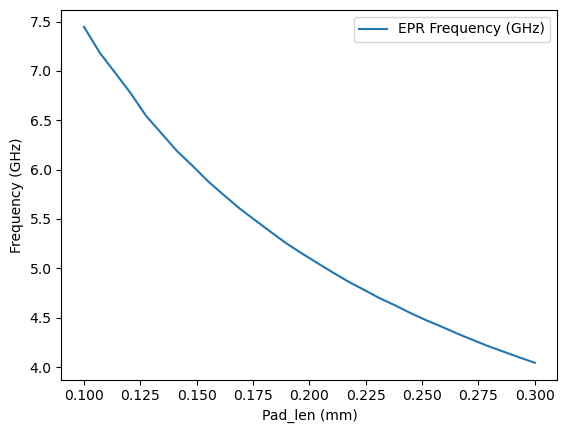

In [8]:
pd.read_csv("Frequencies from metal pad size.csv",).plot(x= 'Pad_len (mm)', y = 'EPR Frequency (GHz)')
plt.ylabel('Frequency (GHz)')
plt.show()

The target frequency is around 4.2GHz. To get this frequency, we need the pad size to be around 0.275mm.

In [6]:
design = designs.DesignPlanar({}, True)
design.chips.main.size['size_x'] = '20 mm'
design.chips.main.size['size_y'] = '10 mm'

design.variables['cpw_width'] = '15 um'
design.variables['cpw_gap'] = '9 um'

design.variables['trace_width'] = '10 um'
design.variables['trace_gap'] = '7 um'

gui = MetalGUI(design)

### Draw the single pad transmon

In [311]:
design.overwrite_enabled = True
# def find_Cap_h(size):

size = 0.25*u.mm
gap = 30*u.um
size = size.to(u.um)
pocket_width = size+2*gap
#design.delete_all_components()

options = dict(pad_width = '{}'.format(size),
pocket_width = '{}'.format(pocket_width),
pad_pocket_distance_top = '40um',
pos_x = '0',
pad_height = '{}um'.format(size.value),
pos_y = '0',
connection_pads = dict(
    a = dict(loc_W  = -1, 
            loc_H =  1, 
            pad_gap = '10um',
            pad_height = '20um',
            pad_width = '140um',
            pad_cpw_extent =  '10um',
            pocket_rise = '0um',
            cpw_extend = '5um')))

q1 = TransmonPocket_Single(design,'Q1',options = options)

gui.rebuild()
gui.zoom_on_components(['Q1'])




In [312]:
q1.options.hfss_inductance = '13nH'
q1.options.q3d_inductance =  '13nH'
gui.rebuild()
gui.autoscale()

In [254]:
c1 = LOManalysis(design, "q3d")
c1.sim.setup.min_passes  = 10
c1.sim.setup.max_passes = 30

c1.sim.run(components=['Q1'], open_terminations=[('Q1', 'a')])#, ('Q1', 'bus1'), ('Q1', 'bus2')])
c1.sim.capacitance_matrix 

c1.sim._get_results_from_renderer()
c_mat = c1.sim.capacitance_matrix
    
    # print(c_mat)
    
    # return(c_mat, design, q1)

INFO 01:01PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 01:01PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 01:01PM [analyze]: Analyzing setup Setup
INFO 01:02PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpzujbulwl.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 01:02PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpbsonziqh.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 01:02PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpziyu9kyr.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 01:02PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpjtezuqfk.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

In [255]:
c_mat

,a_connector_pad_Q1,ground_main_plane,pad_top_Q1
a_connector_pad_Q1,32.71316,-20.07680,-12.25923
ground_main_plane,-20.07680,157.07354,-96.34495
pad_top_Q1,-12.25923,-96.34495,113.36098


In [12]:
# size = 0.25*u.mm

In [13]:
# c_mat, design, qubit = find_Cap_h(size)
# gui.rebuild()
# gui.autoscale()

In [260]:
eig_qb = EPRanalysis(design, 'hfss')

eig_qb.sim.setup.max_passes = 25
eig_qb.sim.setup.max_delta_f = 0.05
eig_qb.sim.setup.n_modes = 1
eig_qb.sim.setup.vars = Dict(Lj1= '13 nH', Cj1= '0 fF')
eig_qb.sim.renderer.options['x_buffer_width_mm'] = 0.5
eig_qb.sim.renderer.options['y_buffer_width_mm'] = 0.5
eig_qb.sim.run(name="Transmons_{}".format(0), components=['Q1'], open_terminations=[('Q1', 'a')])
convergence = pd.read_csv('hfss_eig_f_convergence.csv')

INFO 01:06PM [connect_project]: Connecting to Ansys Desktop API...
INFO 01:06PM [load_ansys_project]: 	Opened Ansys App
INFO 01:06PM [load_ansys_project]: 	Opened Ansys Desktop v2021.2.0
INFO 01:06PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/slab/Documents/Ansoft/
	Project:   Project24
INFO 01:06PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 01:06PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 01:06PM [connect]: 	Connected to project "Project24" and design "Design_q3d" 😀 

INFO 01:06PM [connect_design]: 	Opened active design
	Design:    Transmons_0_hfss [Solution type: Eigenmode]
WARNING 01:06PM [connect_setup]: 	No design setup detected.
WARNING 01:06PM [connect_setup]: 	Creating eigenmode default setup.
INFO 01:06PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 01:06PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 01:06PM 

In [261]:
del eig_qb.setup.junctions['jj']
eig_qb.setup.junctions.jj1 = Dict(rect='JJ_rect_Lj_Q1_rect_jj', line='JJ_Lj_Q1_rect_jj_',
                Lj_variable='Lj1', Cj_variable='Cj1')
eig_qb.setup.sweep_variable = 'Lj1'
eig_qb.run_epr()

chi = eig_qb.sim.renderer.epr_quantum_analysis.get_chis().to_numpy()[0][0]
freq_EPR= eig_qb.sim.renderer.epr_quantum_analysis.get_frequencies().to_numpy()[0][0]

Design "Transmons_0_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_0_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 1.01785010059477e-25
        energy_elec_substrate = 9.38221558416262e-26
        EPR of substrate = 92.2%

        energy_mag    = 6.30050839805333e-28
        energy_mag % of energy_elec_all  = 0.6%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 4.14 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})

  Qp = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.4%  5.089e-26  3.15e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 98.27%
	jj1             0.992502  (+)        0.0174449
		(U_tot_cap-U_tot_ind)/mean=0.93%
Calculating Qdielectric_main for mode 0 (0/0)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9217679085240765


  options=pd.Series(get_instance_vars(self.options)),

WARNING 01:11PM [__init__]: <p>Error: <class 'IndexError'></p>
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project24\Transmons_0_hfss\2023-02-23 13-10-58.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.018836
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.975485

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       168

*** Chi matrix ND (MHz) 
       184

*** Frequencies O1 PT (MHz)
0    3969.965074
dtype: float64

*** Frequencies ND (MHz)
0    3962.458176
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,3962.46


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,184.15


In [262]:
print('Frequency from Finite Element Analysis:', convergence.dropna()['re(Mode(1)) [g]'].values[-1], 'GHz')
print('Frequency from pyEPR analysis:', freq_EPR/1000, 'GHz')

Frequency from Finite Element Analysis: 4.13811343801378 GHz
Frequency from pyEPR analysis: 3.9624581762863293 GHz


### Draw the end pins and the CPW

In [342]:
#This is a function to generate needed pins for CPW drawing. 
import numpy as np
from collections import OrderedDict

def slice_dict(n,anchor):
    res = OrderedDict()
    if n<0:
        m = len(anchor)+n
    else:
        m = min(n,len(anchor))
    for i in range(m):
        res[i] = anchor[i]
    return res

def pins_for_spiral(radius,gap,n,dis = (0,0), r = np.inf, right = True):
    spiral_list = OrderedDict()
    x,y = dis
    print('1',x,y)
    i = 0
    if right:
        for step in range(n):
            point_value = radius / 2 + step * (0 + gap)
            spiral_list[step*4] = np.array([x+point_value, y-point_value])
            spiral_list[step*4+1] = np.array([x-point_value, y-point_value])
            spiral_list[step*4+2] = np.array([x-point_value, y+point_value])
            spiral_list[step*4+3] = np.array([x+point_value + (0 + gap), y+point_value])

        point_value = radius / 2 + (step + 1) * (0 + gap)
    else:
        for step in range(n):
            point_value = radius / 2 + step * (0 + gap)
            spiral_list[step*4] = np.array([x-point_value, y+point_value])
            spiral_list[step*4+1] = np.array([x+point_value, y+point_value])
            spiral_list[step*4+2] = np.array([x+point_value, y-point_value])
            spiral_list[step*4+3] = np.array([x-point_value + (0 - gap), y+point_value])

        point_value = radius / 2 + (step + 1) * (0 + gap)
        spiral_list[step*4+4] = np.array([point_value, point_value])
    
    final_list = slice_dict(r,spiral_list)
    
    return(final_list)

In [343]:
def anchor_CPW(qubit, buffer, wrap_gap, n, r = np.Inf, right = False):
    pocket_width = design.parse_value(qubit.options['pocket_width'])*u.mm
    cpad_height = design.parse_value(qubit.options['pad_height'])*u.mm
    distance_top = design.parse_value(qubit.options['pad_pocket_distance_top'])*u.mm
    jj_len = design.parse_value(qubit.options['jj_length'])*u.mm
    pocket_height = cpad_height + distance_top + jj_len
    
    wrap_r = max(pocket_width,pocket_height)+buffer
    
    x =design.parse_value(qubit.options['pos_x'])
    y =design.parse_value(qubit.options['pos_y'])
    print(x,y)
    
    anchors = pins_for_spiral(wrap_r.value, wrap_gap, n, dis = (x,y), right = right, r = r)
    return anchors
    
    

In [159]:
qubit =  q1

pocket_width = design.parse_value(qubit.options['pocket_width'])*u.mm
cpad_height = design.parse_value(qubit.options['pad_height'])*u.mm
distance_top = design.parse_value(qubit.options['pad_pocket_distance_top'])*u.mm
jj_len = design.parse_value(qubit.options['jj_length'])*u.mm
pocket_height = cpad_height + distance_top + jj_len

In [213]:
buffer = 150*u.um
wrap_r = max(pocket_width,pocket_height)+buffer

In [302]:

TQ_options = dict(prime_width = design.variables['cpw_width'],
               prime_gap = design.variables['cpw_gap'],
               second_width = '10um',
               second_gap = '7um',
               downlength = '10um',
               coupling_space = '5um',
               open_termination=False)

TQ1 = CoupledLineTee(design, 'TQ1', options=dict(pos_x='0.2 mm',
                                             pos_y='0.5 mm',
                                             coupling_length='120 um', **TQ_options))
# TQ2 = CoupledLineTee(design, 'TQ2', options=dict(pos_x='0.15 mm',
#                                              pos_y='0.5 mm',
#                                              coupling_length='120 um', mirror = True, **TQ_options))

gui.rebuild()
gui.autoscale()

In [222]:
anchors = pins_for_spiral(wrap_r.value, 0.07, 1, dis = (0,0), right = False, r = -1)
print(anchors)

OrderedDict([(0, array([-0.24,  0.24])), (1, array([0.24, 0.24])), (2, array([ 0.24, -0.24])), (3, array([-0.31,  0.24]))])


In [224]:
design.delete_component('cpw_1')

gui.rebuild()
gui.autoscale()

In [313]:
options = Dict(trace_width = '10um',
               trace_gap  = '7um',
        total_length='5 mm',
        hfss_wire_bonds = True,
        q3d_wire_bonds = True,
        fillet='30 um',
        lead = dict(start_straight='20um', end_straight = '50um'),
        anchors = anchors,
        pin_inputs=Dict(
            start_pin=Dict(component='Q1', pin='a'),
            end_pin=Dict(component='TQ1', pin='second_end')), )

In [314]:
qa = RouteMixed(design, 'cpw_1', options)

gui.rebuild()
gui.autoscale()

In [271]:
qa.length

2.764367228626928

In [437]:
def find_total_len(cpw, qubit, TQ1, count_extend = False):
    pocket_width = design.parse_value(qubit.options['pocket_width'])*u.mm
    cpad_height = design.parse_value(qubit.options['pad_height'])*u.mm
    gap = (pocket_width-cpad_height)/2
    TQs = TQ1.options['down_length'] + '+' + TQ1.options['coupling_length'] + '+' + TQ1.options['down_length']
    
    if count_extend:
        QBextended = qubit.options['connection_pads']['a']['pad_width'] + '+'+ qubit.options['connection_pads']['a']['cpw_extend']
    else:
        QBextended = '0'
        
    cpw_length = gap + cpw.length*u.mm + design.parse_value(TQs  + '+' + QBextended )*u.mm
    
    return(cpw_length)
        
        

In [433]:
gap = (pocket_width-cpad_height)/2
TQs = TQ1.options['down_length'] + '+' + TQ1.options['coupling_length'] + '+' + TQ1.options['down_length']
QBextended = '0'
#qubit.options['connection_pads']['a']['pad_width'] + '+'+ qubit.options['connection_pads']['a']['cpw_extend']

cpw_length = gap + qa.length*u.mm + design.parse_value(TQs  + '+' + QBextended )*u.mm #+ connector_len + gap

In [434]:
cpw_length

<Quantity 3058.86722863 um>

In [243]:
from Transmon_property import find_guided_wavelength, find_actual_frequency

In [244]:
frequency = 7*u.GHz
line_width = 15*u.um
line_gap = 9*u.um

In [305]:
find_guided_wavelength(frequency, 10*u.um, 7*u.um).to(u.mm)/4

  k1 = np.sinh((np.pi * s) / (4 * h)) / (np.sinh(



<Quantity 3.16414493 mm>

In [275]:
find_actual_frequency(cpw_length, line_width, line_gap)

<Quantity 7.3235202 GHz>

In [435]:
find_actual_frequency(qa.length*u.mm, 10*u.um, 7*u.um)

  k1 = np.sinh((np.pi * s) / (4 * h)) / (np.sinh(



<Quantity 7.99930537 GHz>

In [278]:
(c.c/cpw_length/4).to(u.GHz)

<Quantity 24.78141999 GHz>

In [296]:
design.delete_component('cpw_1')
design.delete_component('Q1')
gui.rebuild()
gui.autoscale()

09:04PM 54s INFO [delete_component]: Called delete_component Q1, but such a component is not in the design cache dictionary of components.


In [297]:
otg_options = Dict(pos_x = '-0.16',pos_y = '0.15', width = '10um', gap = '7um')

otg = OpenToGround(design,'otg', otg_options)

In [300]:
options = Dict(trace_width = '10um',
               trace_gap  = '7um',
        total_length='5 mm',
        hfss_wire_bonds = True,
        q3d_wire_bonds = True,
        fillet='30 um',
        lead = dict(start_straight='20um', end_straight = '50um'),
        anchors = anchors,
        pin_inputs=Dict(
            start_pin=Dict(component='otg', pin  = 'open'),
            end_pin=Dict(component='TQ1', pin='second_end')), )

In [301]:
qa = RouteMixed(design, 'cpw_1', options)

gui.rebuild()
gui.autoscale()

In [304]:
eig_res = EPRanalysis(design, 'hfss')

eig_res.sim.setup.max_passes = 25
eig_res.sim.setup.max_delta_f = 0.05
eig_res.sim.setup.n_modes = 2
eig_res.sim.setup.vars = Dict(Lj1= '13 nH', Cj1= '0 fF')
eig_res.sim.renderer.options['x_buffer_width_mm'] = 0.5
eig_res.sim.renderer.options['y_buffer_width_mm'] = 0.5
eig_res.sim.run(name="all_freqs", components=['cpw_1','TQ1','otg'])#, open_terminations=[('Q1', 'a')])
convergence = pd.read_csv('hfss_eig_f_convergence.csv')

INFO 09:13PM [connect_design]: 	Opened active design
	Design:    all_freqs_hfss [Solution type: Eigenmode]
INFO 09:13PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 09:13PM [analyze]: Analyzing setup Setup
09:17PM 06s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


In [309]:
convergence.dropna()['re(Mode(1)) [g]'].values[-1]*u.GHz

<Quantity 9.92276537 GHz>

In [310]:
design.delete_component('cpw_1')
design.delete_component('otg')
gui.rebuild()
gui.autoscale()

In [264]:
eig_qb_cpw = EPRanalysis(design, 'hfss')

eig_qb_cpw.sim.setup.max_passes = 25
eig_qb_cpw.sim.setup.max_delta_f = 0.05
eig_qb_cpw.sim.setup.n_modes = 3
eig_qb_cpw.sim.setup.vars = Dict(Lj1= '13 nH', Cj1= '0 fF')
eig_qb_cpw.sim.renderer.options['x_buffer_width_mm'] = 0.5
eig_qb_cpw.sim.renderer.options['y_buffer_width_mm'] = 0.5
eig_qb_cpw.sim.run(name="all_freqs", components=['Q1','cpw_1','TQ1'])#, open_terminations=[('Q1', 'a')])
convergence = pd.read_csv('hfss_eig_f_convergence.csv')

INFO 01:14PM [connect_design]: 	Opened active design
	Design:    all_freqs_hfss [Solution type: Eigenmode]
WARNING 01:14PM [connect_setup]: 	No design setup detected.
WARNING 01:14PM [connect_setup]: 	Creating eigenmode default setup.
INFO 01:14PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 01:14PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 01:14PM [analyze]: Analyzing setup Setup
02:59PM 52s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


In [265]:
del eig_qb_cpw.setup.junctions['jj']
eig_qb_cpw.setup.junctions.jj1 = Dict(rect='JJ_rect_Lj_Q1_rect_jj', line='JJ_Lj_Q1_rect_jj_',
                Lj_variable='Lj1', Cj_variable='Cj1')
eig_qb_cpw.setup.sweep_variable = 'Lj1'
eig_qb_cpw.run_epr()

chi = eig_qb_cpw.sim.renderer.epr_quantum_analysis.get_chis().to_numpy()[0][0]
freq_EPR= eig_qb_cpw.sim.renderer.epr_quantum_analysis.get_frequencies().to_numpy()[0][0]

Design "all_freqs_hfss" info:
	# eigenmodes    3
	# variations    1
Design "all_freqs_hfss" info:
	# eigenmodes    3
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 2.56306879484299e-26
        energy_elec_substrate = 2.36095027362388e-26
        EPR of substrate = 92.1%

        energy_mag    = 2.31839388425387e-28
        energy_mag % of energy_elec_all  = 0.9%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 4.03 GHz   [1/3]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.1%  1.282e-26 1.159e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 98.36%
	jj1             0.990636  (+)        0.0164836
		(U_tot_cap-U_tot_ind)/mean=0.83%
Calculating Qdielectric_main for mode 0 (0/2)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9211419835371638


  _Om = pd.Series({})




  Mode 1 at 9.46 GHz   [2/3]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
                0.3%   1.68e-26 1.676e-26

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_1j   sign s_1j    (p_capacitive)


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 91.59%
	jj1             0.00250125  (+)        0.000229682
		(U_tot_cap-U_tot_ind)/mean=0.01%
Calculating Qdielectric_main for mode 1 (1/2)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_1 = 0.9205470526609205


  _Om = pd.Series({})




  Mode 2 at 28.13 GHz   [3/3]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               -0.8%  1.642e-26 1.654e-26

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_2j   sign s_2j    (p_capacitive)


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 55.18%
	jj1             9.03204e-05  (+)        7.33762e-05
		(U_tot_cap-U_tot_ind)/mean=-0.39%
Calculating Qdielectric_main for mode 2 (2/2)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_2 = 0.9209669837801766


  options=pd.Series(get_instance_vars(self.options)),

WARNING 05:26PM [__init__]: <p>Error: <class 'IndexError'></p>



ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project24\all_freqs_hfss\2023-02-23 17-24-41.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization


  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions



Pm_norm=
modes
0     1.016885
1     1.046236
2    41.718963
dtype: float64

Pm_norm idx =
     jj1
0   True
1  False
2  False
*** P (participation matrix, not normlz.)
        jj1
0  0.974571
1  0.002501
2  0.000090

*** S (sign-bit matrix)
   s_jj1
0     -1
1     -1
2      1
*** P (participation matrix, normalized.)
      0.99
    0.0025
     9e-05

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       158     1.88    0.202
      1.88  0.00556  0.00119
     0.202  0.00119 6.42e-05

*** Chi matrix ND (MHz) 
       173     2.04      0.2
      2.04  0.00555  0.00111
       0.2  0.00111 6.37e-05

*** Frequencies O1 PT (MHz)
0     3866.957647
1     9457.474400
2    28133.035045
dtype: float64

*** Frequencies ND (MHz)
0     3860.023562
1     9457.425257
2    28133.035578
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1, 2]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,3860.02
1,9457.43
2,28133.04


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

0         1         2
Lj1                              
13  0  173.16  2.04e+00  2.00e-01
    1    2.04  5.55e-03  1.11e-03
    2    0.20  1.11e-03  6.37e-05

In [315]:
chi

173.16298627369022

In [499]:
freq_EPR

3860.0235620350777

In [500]:
eig_qb_cpw.sim.renderer.epr_quantum_analysis.get_frequencies().to_numpy()

array([[ 3860.02356204],
       [ 9457.42525686],
       [28133.03557817]])

# Two Qubit design

In [374]:
design.delete_all_components()

In [390]:
size1 = 250*u.um
size2 = 200*u.um
gap = 30*u.um
size = size.to(u.um)
pocket_width1 = size1+2*gap
pocket_width2 = size2+2*gap
#design.delete_all_components()

options = dict(
pad_pocket_distance_top = '40um',
connection_pads = dict(
    a = dict(loc_W  = -1, 
            loc_H =  1, 
            pad_gap = '10um',
            pad_height = '20um',
            pad_width = '140um',
            pad_cpw_extent =  '10um',
            pocket_rise = '0um',
            cpw_extend = '5um')))

q1 = TransmonPocket_Single(design,'Q1', 
                           options = Dict(pocket_width = '{}'.format(pocket_width1),
                                          pad_width = '{}'.format(size), 
                           pad_height = '{}'.format(size),
                           pos_x = '0', pox_y = '0', **options))
q2 = TransmonPocket_Single(design,'Q2',
                           options = Dict(pocket_width = '{}'.format(pocket_width2),
                                          pad_width = '{}'.format(size-50*u.um), 
                           pad_height = '{}'.format(size-50*u.um),
                           pos_x = '0.5', pox_y = '0', **options))

gui.rebuild()
gui.zoom_on_components(['Q1', 'Q2'])

In [432]:
TQ_options = dict(prime_width = design.variables['cpw_width'],
               prime_gap = design.variables['cpw_gap'],
               second_width = '10um',
               second_gap = '7um',
               down_length = '70um',
               coupling_space = '5um',
               open_termination=False)

TQ1 = CoupledLineTee(design, 'TQ1', options=dict(pos_x='-0.2 mm',
                                             pos_y='0.5 mm', mirror = True,
                                             coupling_length='120 um', **TQ_options))

TQ2 = CoupledLineTee(design, 'TQ2', options=dict(pos_x='0.5 mm',
                                             pos_y='0.5 mm',
                                             coupling_length='120 um', **TQ_options))
gui.rebuild()
gui.autoscale()

In [429]:
anchor[1]

array([0.215, 0.215])

In [430]:
anchor = anchor_CPW(q1, 100*u.um,0.05,1, r = -1)
last = anchor[len(anchor)-1]
first = anchor[1]
anchor[len(anchor)] = np.array([first[0],last[1]+0.05])

design.delete_component('cpw_1')
options = Dict(trace_width = '10um',
               trace_gap  = '7um',
        total_length='3 mm',
        hfss_wire_bonds = True,
        q3d_wire_bonds = True,
        fillet='30 um',
        lead = dict(start_straight='20um', end_straight = '50um'),
        anchors = anchor,
        pin_inputs=Dict(
            start_pin=Dict(component='Q1', pin  = 'a'),
            end_pin=Dict(component='TQ1', pin='second_end')), )

cpw1 = RouteMixed(design, 'cpw1', options)

gui.rebuild()
gui.autoscale()

10:19PM 48s INFO [delete_component]: Called delete_component cpw_1, but such a component is not in the design cache dictionary of components.


0.0 0.0
1 0.0 0.0


In [440]:
len1 = find_total_len(cpw1, q1,TQ1)
print(len1)
find_actual_frequency(len1, 10*u.um, 7*u.um)

  k1 = np.sinh((np.pi * s) / (4 * h)) / (np.sinh(



3.2031150082346214 mm


<Quantity 6.91483585 GHz>

In [431]:
anchor = anchor_CPW(q2, 100*u.um, 0.05, 1,r = -1)
last = anchor[len(anchor)-1]
first = anchor[1]
anchor[len(anchor)] = np.array([first[0],last[1]+0.05])

design.delete_component('cpw_1')
options = Dict(trace_width = '10um',
               trace_gap  = '7um',
        total_length='3 mm',
        hfss_wire_bonds = True,
        q3d_wire_bonds = True,
        fillet='30 um',
        lead = dict(start_straight='20um', end_straight = '50um'),
        anchors = anchor,
        pin_inputs=Dict(
            start_pin=Dict(component='Q2', pin  = 'a'),
            end_pin=Dict(component='TQ2', pin='second_end')), )

cpw2 = RouteMixed(design, 'cpw2', options)

gui.rebuild()
gui.autoscale()

10:20PM 05s INFO [delete_component]: Called delete_component cpw_1, but such a component is not in the design cache dictionary of components.


0.5 0.0
1 0.5 0.0


In [442]:
len2 = find_total_len(cpw2, q2,TQ1)
print(len2)
find_actual_frequency(len2, 10*u.um, 7*u.um)

  k1 = np.sinh((np.pi * s) / (4 * h)) / (np.sinh(



2.633115008234621 mm


<Quantity 8.41171557 GHz>

In [443]:
c = LOManalysis(design, "q3d")
c.sim.setup.min_passes  = 10
c.sim.setup.max_passes = 30



{'name': 'Setup',
 'reuse_selected_design': True,
 'reuse_setup': True,
 'freq_ghz': 5.0,
 'save_fields': False,
 'enabled': True,
 'max_passes': 30,
 'min_passes': 10,
 'min_converged_passes': 2,
 'percent_error': 0.5,
 'percent_refinement': 30,
 'auto_increase_solution_order': True,
 'solution_order': 'High',
 'solver_type': 'Iterative'}

In [445]:
c.sim.run(components=['Q1','Q2','cpw1','cpw2','TQ1','TQ2'])
c.sim.capacitance_matrix 

c.sim._get_results_from_renderer()
c_mat = c.sim.capacitance_matrix

INFO 10:35PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:35PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:35PM [analyze]: Analyzing setup Setup
INFO 10:37PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpkwkqh3j5.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:37PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpsp3_0h1p.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:37PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpc_6jssaz.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:37PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpq3d159t_.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

In [450]:
c_mat

,a_connector_pad_Q1,pad_top_Q1,pad_top_Q2
a_connector_pad_Q1,265.69045,-111.63073,-86.27845
pad_top_Q1,-111.63073,114.97523,-0.96692
pad_top_Q2,-86.27845,-0.96692,88.92040


In [480]:
C = c_mat.values[1:,1:]

In [486]:
C

array([[114.97523,  -0.96692],
       [ -0.96692,  88.9204 ]])

In [464]:
C = np.array([[80,-1],[-1,80]])

In [482]:
l = 10
L = np.array([[1/l,0],[0,1/l]])

In [456]:
import qutip as q
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as c
import scipy.linalg as lin

In [487]:
r = lin.eig(lin.inv(C)@(L))


In [488]:
np.sqrt(r[0])*1000

array([29.48697281+0.j, 33.54183529+0.j])

In [498]:
(1/np.sqrt(13*u.nH*100*u.fF).si).to(u.GHz)/2/np.pi

<Quantity 4.41416391 GHz>

In [496]:
from Transmon_property import transmon_freq

In [497]:
transmon_freq(110*u.fF, 13*u.nH)

(<Quantity 4.03264716 GHz>, <Quantity 176.09299386 MHz>)

# Simulations

## Capacitance Matrix Calculation

Note that when we calculate capacitance matrix, we need to ``approximate" that the end pins of the CPW is not grounded to get the capacitance coupling. Thus we need to modify the designs above to get the desired capacitance matrix. 

In [14]:
draw_CPW(short=False)

In [15]:
from qiskit_metal.analyses.quantization import LOManalysis
c1 = LOManalysis(design, "q3d")

In [16]:
c1.sim.setup.min_passes  = 1
c1.sim.setup.max_passes = 5
print(c1.sim.setup)

{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'freq_ghz': 5.0, 'save_fields': False, 'enabled': True, 'max_passes': 5, 'min_passes': 1, 'min_converged_passes': 2, 'percent_error': 0.5, 'percent_refinement': 30, 'auto_increase_solution_order': True, 'solution_order': 'High', 'solver_type': 'Iterative'}


In [17]:
c1.sim.run(components=['Q1','cpw_1','end'])#, open_terminations=[('end', 'a')])#, ('Q1', 'bus1'), ('Q1', 'bus2')])
c1.sim.capacitance_matrix 

c1.sim._get_results_from_renderer()
c_mat = c1.sim.capacitance_matrix

INFO 03:43PM [connect_project]: Connecting to Ansys Desktop API...
INFO 03:43PM [load_ansys_project]: 	Opened Ansys App
INFO 03:43PM [load_ansys_project]: 	Opened Ansys Desktop v2021.2.0
INFO 03:43PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/slab/Documents/Ansoft/
	Project:   Project14
INFO 03:43PM [connect_design]: 	Opened active design
	Design:    TwoTransmons_hfss [Solution type: Eigenmode]
INFO 03:43PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 03:43PM [connect]: 	Connected to project "Project14" and design "TwoTransmons_hfss" 😀 

INFO 03:43PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
WARNING 03:43PM [connect_setup]: 	No design setup detected.
WARNING 03:43PM [connect_setup]: 	Creating Q3D default setup.
INFO 03:43PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 03:43PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 03:4

In [18]:
c_mat

,a_connector_pad_Q1,g_wb,pad_top_Q1
a_connector_pad_Q1,664.98231,-642.09047,-18.99471
g_wb,-642.09047,784.66027,-77.15847
pad_top_Q1,-18.99471,-77.15847,98.09671


In the capacitance matrix above, the ground plane is named "g_wb" The big metal pad in the junction pocket is called "pad_top_Q1" The CPW is connected with the connector pad, thus its name is "a_connector_pad"

In [19]:
c1.clear_data()

## EPR Analysis

In [20]:
import numpy as np
from qiskit_metal.analyses.quantization import EPRanalysis

In [21]:
hfss.clean_active_design()

NameError: name 'hfss' is not defined

INFO 03:48PM [connect_project]: Connecting to Ansys Desktop API...
INFO 03:48PM [load_ansys_project]: 	Opened Ansys App
INFO 03:48PM [load_ansys_project]: 	Opened Ansys Desktop v2021.2.0
INFO 03:48PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/slab/Documents/Ansoft/
	Project:   Project14
INFO 03:48PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 03:48PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 03:48PM [connect]: 	Connected to project "Project14" and design "Design_q3d" 😀 

03:48PM 33s WARNING [activate_ansys_design]: The design_name=readout was not in active project.  Designs in active project are: 
['Qbit_hfss', 'Design_q3d', 'TwoTransmons_hfss', 'TransmonResonator_hfss', 'Readout_hfss'].  A new design will be added to the project.  
INFO 03:48PM [connect_design]: 	Opened active design
	Design:    readout [Solution type: Eigenmode]
WARNING 03:48PM [connect_setup]: 	No design setup det

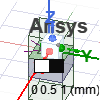

INFO 03:48PM [analyze]: Analyzing setup Setup



Number of eigenmodes to find             = 2
Number of simulation passes              = 40
Convergence freq max delta percent diff  = 0.1



In [22]:

draw_CPW()
# design.delete_component('Q1')
eig_res = EPRanalysis(design, "hfss")

hfss = eig_res.sim.renderer
hfss.start()

hfss.activate_ansys_design('readout','eigenmode')

hfss.render_design(['cpw_1','Q1','end'],[])
hfss.save_screenshot()

setup = hfss.pinfo.setup
setup.passes = 40
setup.min_converged = 9
setup.n_modes = 2

print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

# Next 2 lines are counterinuitive, since there is no junction in this resonator.
# However, these are necessary to make pyEPR work correctly. Please do note delete
hfss.pinfo.design.set_variable('Lj', '10 nH')
hfss.pinfo.design.set_variable('Cj', '0 fF')

setup.analyze()

In [23]:
eig_res.get_frequencies()

Design "readout" info:
	# eigenmodes    2
	# variations    1
Design "readout" info:
	# eigenmodes    2
	# variations    1


Freq. (GHz)  Quality Factor
variation mode                             
0         0        6.336721             inf
          1        7.000849             inf

In [24]:
eig_res.sim.convergence_t, eig_res.sim.convergence_f, _ = hfss.get_convergences()
eig_res.sim.plot_convergences()

03:56PM 47s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


03:56PM 51s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


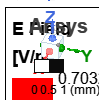

WindowsPath('c:/Users/slab/Desktop/Wendy-qiskit-code/ansys.png')

In [25]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [26]:
hfss.clear_fields(['Mag_E1'])

In [27]:
hfss.set_mode(2, "Setup")

INFO 03:57PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


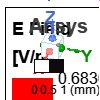

WindowsPath('c:/Users/slab/Desktop/Wendy-qiskit-code/ansys.png')

In [28]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_fields('main')
hfss.save_screenshot()

In [29]:
eig_res.sim.setup

{'name': 'Setup',
 'reuse_selected_design': True,
 'reuse_setup': True,
 'min_freq_ghz': 1,
 'n_modes': 1,
 'max_delta_f': 0.5,
 'max_passes': 10,
 'min_passes': 1,
 'min_converged': 1,
 'pct_refinement': 30,
 'basis_order': 1,
 'vars': {'Lj': '10 nH', 'Cj': '0 fF'}}

In [30]:
eig_res.setup

{'junctions': {'jj': {'Lj_variable': 'Lj',
   'Cj_variable': 'Cj',
   'rect': '',
   'line': ''}},
 'dissipatives': {'dielectrics_bulk': ['main']},
 'cos_trunc': 8,
 'fock_trunc': 7,
 'sweep_variable': 'Lj'}

In [31]:
eig_res.setup.junctions.jj.rect = 'JJ_rect_Lj_Q1_rect_jj'
eig_res.setup.junctions.jj.line = 'JJ_Lj_Q1_rect_jj_'
eig_res.setup

{'junctions': {'jj': {'Lj_variable': 'Lj',
   'Cj_variable': 'Cj',
   'rect': 'JJ_rect_Lj_Q1_rect_jj',
   'line': 'JJ_Lj_Q1_rect_jj_'}},
 'dissipatives': {'dielectrics_bulk': ['main']},
 'cos_trunc': 8,
 'fock_trunc': 7,
 'sweep_variable': 'Lj'}

In [33]:
eig_res.run_epr()

Design "readout" info:
	# eigenmodes    2
	# variations    1
Design "readout" info:
	# eigenmodes    2
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 1.30257249753934e-24
        energy_elec_substrate = 1.19677535080225e-24
        EPR of substrate = 91.9%

        energy_mag    = 9.23737451177308e-25
        energy_mag % of energy_elec_all  = 70.9%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 6.34 GHz   [1/2]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               69.6%  7.452e-26 2.265e-26

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 96.93%
	jj              0.391572  (+)        0.0124145
		(U_tot_cap-U_tot_ind)/mean=18.56%
Calculating Qdielectric_main for mode 0 (0/1)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9208738470290613


  _Om = pd.Series({})




  Mode 1 at 7.00 GHz   [2/2]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               29.1%  6.513e-25 4.619e-25

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_1j   sign s_1j    (p_capacitive)


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 96.27%
	jj              0.163614  (+)        0.00633158
		(U_tot_cap-U_tot_ind)/mean=7.11%
Calculating Qdielectric_main for mode 1 (1/1)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_1 = 0.9187783045189813


  options=pd.Series(get_instance_vars(self.options)),

WARNING 04:01PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 04:01PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 37.1% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 04:01PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 37.1% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project14\readout\2023-02-01 16-01-42.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.665299
1    1.508216
dtype: float64

Pm_norm idx =
     jj
0  True
1  True
*** P (participation matrix, not normlz.)
         jj
0  0.386770
1  0.162585

*** S (sign-bit matrix)
   s_jj
0    -1
1     1
*** P (participation matrix, normalized.)
      0.64
      0.25

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       127      107
       107     22.5

*** Chi matrix ND (MHz) 
       211     62.8
      62.8      6.5

*** Frequencies O1 PT (MHz)
0    6155.757442
1    6924.733448
dtype: float64

*** Frequencies ND (MHz)
0    6130.144212
1    6940.601897
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj,10
0,6130.14
1,6940.60


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

0      1
Lj                 
10 0  211.11  62.83
   1   62.83   6.50

In [5]:
from tqdm import tqdm
import numpy as np
import time

In [8]:
for member in tqdm(np.linspace(0,100,100)):
    time.sleep(0.1)
    print(member)

  2%|▏         | 2/100 [00:00<00:10,  9.31it/s]

0.0
1.0101010101010102


  4%|▍         | 4/100 [00:00<00:10,  9.16it/s]

2.0202020202020203
3.0303030303030303


  6%|▌         | 6/100 [00:00<00:10,  9.10it/s]

4.040404040404041
5.050505050505051


  8%|▊         | 8/100 [00:00<00:10,  9.08it/s]

6.0606060606060606
7.070707070707071


 10%|█         | 10/100 [00:01<00:09,  9.08it/s]

8.080808080808081
9.090909090909092


 12%|█▏        | 12/100 [00:01<00:09,  9.05it/s]

10.101010101010102
11.111111111111112


 14%|█▍        | 14/100 [00:01<00:09,  9.05it/s]

12.121212121212121
13.131313131313131


 16%|█▌        | 16/100 [00:01<00:09,  9.03it/s]

14.141414141414142
15.151515151515152


 18%|█▊        | 18/100 [00:01<00:09,  8.98it/s]

16.161616161616163
17.171717171717173


 20%|██        | 20/100 [00:02<00:08,  9.00it/s]

18.181818181818183
19.191919191919194


 22%|██▏       | 22/100 [00:02<00:08,  9.03it/s]

20.202020202020204
21.212121212121215


 24%|██▍       | 24/100 [00:02<00:08,  9.03it/s]

22.222222222222225
23.232323232323235


 26%|██▌       | 26/100 [00:02<00:08,  9.05it/s]

24.242424242424242
25.252525252525253


 28%|██▊       | 28/100 [00:03<00:07,  9.01it/s]

26.262626262626263
27.272727272727273


 30%|███       | 30/100 [00:03<00:07,  9.06it/s]

28.282828282828284
29.292929292929294


 32%|███▏      | 32/100 [00:03<00:07,  9.01it/s]

30.303030303030305
31.313131313131315


 34%|███▍      | 34/100 [00:03<00:07,  9.02it/s]

32.323232323232325
33.333333333333336


 36%|███▌      | 36/100 [00:03<00:07,  9.08it/s]

34.343434343434346
35.35353535353536


 38%|███▊      | 38/100 [00:04<00:06,  9.07it/s]

36.36363636363637
37.37373737373738


 40%|████      | 40/100 [00:04<00:06,  9.04it/s]

38.38383838383839
39.3939393939394


 42%|████▏     | 42/100 [00:04<00:06,  9.04it/s]

40.40404040404041
41.41414141414142


 44%|████▍     | 44/100 [00:04<00:06,  9.06it/s]

42.42424242424243
43.43434343434344


 46%|████▌     | 46/100 [00:05<00:05,  9.09it/s]

44.44444444444445
45.45454545454546


 48%|████▊     | 48/100 [00:05<00:05,  9.11it/s]

46.46464646464647
47.47474747474748


 50%|█████     | 50/100 [00:05<00:05,  9.03it/s]

48.484848484848484
49.494949494949495


 52%|█████▏    | 52/100 [00:05<00:05,  9.04it/s]

50.505050505050505
51.515151515151516


 54%|█████▍    | 54/100 [00:05<00:05,  9.06it/s]

52.525252525252526
53.535353535353536


 56%|█████▌    | 56/100 [00:06<00:04,  8.99it/s]

54.54545454545455
55.55555555555556


 58%|█████▊    | 58/100 [00:06<00:04,  8.99it/s]

56.56565656565657
57.57575757575758


 60%|██████    | 60/100 [00:06<00:04,  8.98it/s]

58.58585858585859
59.5959595959596


 62%|██████▏   | 62/100 [00:06<00:04,  9.00it/s]

60.60606060606061
61.61616161616162


 64%|██████▍   | 64/100 [00:07<00:03,  9.05it/s]

62.62626262626263
63.63636363636364


 66%|██████▌   | 66/100 [00:07<00:03,  9.10it/s]

64.64646464646465
65.65656565656566


 68%|██████▊   | 68/100 [00:07<00:03,  9.09it/s]

66.66666666666667
67.67676767676768


 70%|███████   | 70/100 [00:07<00:03,  9.05it/s]

68.68686868686869
69.6969696969697


 72%|███████▏  | 72/100 [00:07<00:03,  9.00it/s]

70.70707070707071
71.71717171717172


 74%|███████▍  | 74/100 [00:08<00:02,  9.04it/s]

72.72727272727273
73.73737373737374


 76%|███████▌  | 76/100 [00:08<00:02,  9.04it/s]

74.74747474747475
75.75757575757576


 78%|███████▊  | 78/100 [00:08<00:02,  9.02it/s]

76.76767676767678
77.77777777777779


 80%|████████  | 80/100 [00:08<00:02,  9.05it/s]

78.7878787878788
79.7979797979798


 82%|████████▏ | 82/100 [00:09<00:01,  9.07it/s]

80.80808080808082
81.81818181818183


 84%|████████▍ | 84/100 [00:09<00:01,  9.05it/s]

82.82828282828284
83.83838383838385


 86%|████████▌ | 86/100 [00:09<00:01,  9.04it/s]

84.84848484848486
85.85858585858587


 88%|████████▊ | 88/100 [00:09<00:01,  9.01it/s]

86.86868686868688
87.87878787878789


 90%|█████████ | 90/100 [00:09<00:01,  8.99it/s]

88.8888888888889
89.89898989898991


 92%|█████████▏| 92/100 [00:10<00:00,  9.17it/s]

90.90909090909092
91.91919191919193


 94%|█████████▍| 94/100 [00:10<00:00,  9.18it/s]

92.92929292929294
93.93939393939395


 96%|█████████▌| 96/100 [00:10<00:00,  9.15it/s]

94.94949494949496
95.95959595959597


 98%|█████████▊| 98/100 [00:10<00:00,  9.08it/s]

96.96969696969697
97.97979797979798


100%|██████████| 100/100 [00:11<00:00,  9.06it/s]

98.98989898989899
100.0


## Save Design to GDS

In [18]:
a_gds = design.renderers.gds

In [19]:
a_gds.options

{'short_segments_to_not_fillet': 'True',
 'check_short_segments_by_scaling_fillet': '2.0',
 'gds_unit': 0.001,
 'ground_plane': 'True',
 'negative_mask': {'main': []},
 'fabricate': 'False',
 'corners': 'circular bend',
 'tolerance': '0.00001',
 'precision': '0.000000001',
 'width_LineString': '10um',
 'path_filename': '../resources/Fake_Junctions.GDS',
 'junction_pad_overlap': '5um',
 'max_points': '199',
 'cheese': {'datatype': '100',
  'shape': '0',
  'cheese_0_x': '25um',
  'cheese_0_y': '25um',
  'cheese_1_radius': '100um',
  'view_in_file': {'main': {1: True}},
  'delta_x': '100um',
  'delta_y': '100um',
  'edge_nocheese': '200um'},
 'no_cheese': {'datatype': '99',
  'buffer': '25um',
  'cap_style': '2',
  'join_style': '2',
  'view_in_file': {'main': {1: True}}},
 'bounding_box_scale_x': '1.2',
 'bounding_box_scale_y': '1.2'}

In [20]:
a_gds.options['path_filename'] = 'Customized_Components\Fake_Junctions.GDS'

In [21]:

a_gds.options['short_segments_to_not_fillet'] = 'False'
a_gds.export_to_gds('One pad design.gds')

1

The rest of the notebook is just a scratch paper :D

In [130]:
q3d.clean_active_design()

{'name': 'Setup',
 'reuse_selected_design': True,
 'reuse_setup': True,
 'freq_ghz': 5,
 'max_delta_s': 0.1,
 'max_passes': 10,
 'min_passes': 1,
 'min_converged': 1,
 'pct_refinement': 30,
 'basis_order': 1,
 'vars': {'Lj': '10 nH', 'Cj': '0 fF'},
 'sweep_setup': {'name': 'Sweep',
  'start_ghz': 2.0,
  'stop_ghz': 8.0,
  'count': 101,
  'step_ghz': None,
  'type': 'Fast',
  'save_fields': False}}

In [51]:
import numpy as np
import scipy.linalg as la
import qutip as q
import astropy.units as u
import astropy.constants as con

class Single_Transmon_Circuit:
    ## Default constant
    eq = 1.602e-19*u.C 
    epsilon = con.eps0
    h = 6.636/10**34
    hbar = con.hbar
    kb = con.k_B
    Tc = 1.2
    delta = 1.764*kb*Tc
    phi0 = con.h/2/eq
    dielectric = 9.34*epsilon
    def __init__(self,cap_mat,pad_name,CPW_name,ground_plane_name = 'ground_main_plane') -> None:
        self.c_couple = -cap_mat[pad_name][CPW_name]*u.fF
        self.c_to_ground = cap_mat[pad_name][pad_name]
        self.c_CPW = cap_mat[CPW_name][CPW_name]

In [54]:
Single_Transmon_Circuit(c_mat,'pad_top_Q1','n_spiral_spiral')